In [239]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from umap import UMAP

In [41]:
rooturl = 'https://www.altinget.dk'
url = 'https://www.altinget.dk/kandidater/ft19/stemmeseddel.aspx'

In [16]:
# Data for at søge på siden:
data = {
    'storkreds':'',
    'top': '0',
    'erhverv':'',
    'aldersgrupper': 'all',
    'gender': '0',
    'parties': '',
    'fritekst': ''
}

In [20]:
# Get main page
response = requests.post(url, data=data)
soup = BeautifulSoup(response.text)

In [110]:
# Find list of all candidates
CandidateList = soup.find('div',attrs={'class': 'candidates-list'}).find_all('a')

In [103]:
ans2coor = {'Helt uenig': -2,
            'Overvejende uenig': -1,
            'Overvejende enig': 1,
            'Helt enig': 2}

In [108]:
def get_candidate(CandidateLink):
    kandidat = {}
    kandidat['navn'] = CandidateLink.text
    subpage = requests.get(rooturl + CandidateLink['href'])
    subsoup = BeautifulSoup(subpage.text)
    # Get some info
    keys = ['parti', 'kreds', 'storkreds']
    info = re.findall(r':.*', subsoup.find(attrs={'class':'byline-details'}).text)
    for k,v in zip(keys, info):
        kandidat[k] = v[2:-1]
    # Get answers
    svar = [x.parent.find('span').text for x in subsoup.find_all(attrs={'class':"answer-candidate"})]
    kandidat['svar'] = [ans2coor[ans] for ans in svar]
    
    return kandidat

In [129]:
N = len(CandidateList)
kandidater = []
fails = []
for i,link in enumerate(CandidateList):
    print(f'{i+1}/{N}',end='\r')
    sleep(0.1)
    try:
        kandidater.append(get_candidate(link))
    except:
        fails.append((i, link))

In [525]:
df = pd.DataFrame(kandidater)
df.to_json('rawdata.json', orient='records', force_ascii=False)

In [423]:
# Remove candidates without answers
newdf = df[df.astype(str)['svar'] != '[]']

In [424]:
partier = newdf.parti.unique()
partier

array(['Radikale Venstre', 'Enhedslisten - De Rød-Grønne',
       'SF - Socialistisk Folkeparti', 'Dansk Folkeparti',
       'Liberal Alliance', 'Socialdemokratiet',
       'Det Konservative Folkeparti', 'Alternativet',
       'Kristendemokraterne', 'Klaus Riskær Pedersen',
       'Venstre, Danmarks Liberale Parti', 'Nye Borgerlige', 'Stram Kurs',
       'Uden for partierne'], dtype=object)

In [426]:
symboler = ['B', 'Ø', 'F', 'O', 'I', 'S', 'C', 'Å', 'K', 'E', 'V', 'D', 'P', 'UP']
partisymboler = {k: v for k,v in zip(partier,symboler)}

In [433]:
# Fix kreds/storkreds
mask = newdf['storkreds'].isna()
newdf['storkreds'][mask] = newdf['kreds'][mask]

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [427]:
# Add symbols
newdf['symbol'] = newdf['parti'].map(partisymboler)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [439]:
newdf.drop(columns=['kreds','parti'], inplace=True)
newdf.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,navn,storkreds,svar,symbol
0,Abbas Razvi,Københavns Omegns Storkreds,"[1, 1, 2, 2, 2, 2, 1, 2, -2, 1, 2, 1, -2, 1, 1...",B
1,Aksel Rosager Johansen,Vestjyllands Storkreds,"[1, -2, 1, 1, 2, 2, -2, 2, -2, 2, 2, 2, -2, -2...",Ø
2,Aleksander Myrhøj,Østjyllands Storkreds,"[2, -2, 1, -1, 2, 2, -2, 2, -2, 1, 2, 1, -2, -...",F
3,Alex Rosenbæk,Vestjyllands Storkreds,"[-2, -2, 1, 2, 2, -1, 1, 1, -2, -2, -2, -2, -1...",O
4,Alex Ahrendtsen,Fyns Storkreds,"[-2, 2, -2, -2, 2, 2, -2, 2, -1, -2, -2, -2, 2...",O


In [ ]:
listdf = pd.DataFrame(index=symboler)

In [914]:
listdf['longname'] = partier
listdf['shortname'] = ['Radikale Venstre', 'Enhedslisten',
       'Socialistisk Folkeparti', 'Dansk Folkeparti',
       'Liberal Alliance', 'Socialdemokratiet',
       'Konservative', 'Alternativet',
       'Kristendemokraterne', 'Klaus Riskær Pedersen',
       'Venstre', 'Nye Borgerlige', 'Stram Kurs',
       'Uden for partierne']
listdf['farve'] = ['#CD247B','#BA2C4B','#E22626','#F8CE2F','#46ACD2','#C8112E','#0F7E40','#78B637','#ED7843','#528583','#0B5B98','#538EA8','#000000','#797768']
listdf['farve'] = ['#FF69B4','#712981','#FF0000','#F8CE2F','#46ACD2','#C8112E','#0F7E40','#78B637','#ED7843','#528583','#0B5B98','#538EA8','#000000','#797768']
listdf['fork'] = ['RV','EL','SF','DF','LA','S','K','ALT','KD','KRP','V','NB','SK','UP']

In [969]:
partiledere = ['Lars Løkke Rasmussen',
                'Pernille Skipper',
               'Anders Samuelsen',
               'Morten Østergaard',
               'Mette Frederiksen',
              'Klaus Riskær Pedersen',
              'Kristian Thulesen Dahl',
              'Søren Pape Poulsen',
              'Pernille Vermund',
              'Stig Grenov',
              'Uffe Elbæk',
              'Pia Olsen Dyhr',
              'Rasmus Paludan']

In [441]:
# Calculate cartainty
newdf['certainty'] = newdf.svar.map(lambda x: (np.abs(np.array(x)) == 2).sum())

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1505]:
newdf.nlargest(5, 'certainty')
newdf.nsmallest(5, 'certainty')

,navn,storkreds,svar,symbol,certainty,partidist,closest,gmm,kmeans
646,Nils Sjøberg,Sydjyllands Storkreds,"[1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -...",B,0,5.011400,B,1,B
472,Lars Aslan Rasmussen,Københavns Storkreds,"[-1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1,...",S,1,6.743127,S,5,B
347,Jeppe Bruus,Københavns Omegns Storkreds,"[1, -1, 1, -1, 1, 1, -1, 2, -1, -1, 1, -1, 1, ...",S,3,3.647609,S,5,S
591,Michael Lange,Københavns Storkreds,"[2, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1,...",V,3,5.960828,C,6,C
652,Ole Pedersen,Fyns Storkreds,"[1, 1, 1, -1, 2, -1, 1, 1, -1, -1, -1, -1, 1, ...",V,3,4.983986,V,8,V


In [470]:
listdf['certainty'] = listdf.index.map(lambda s: newdf[newdf.symbol == s].certainty.mean())

In [471]:
listdf.sort_values('certainty')

,longname,shortname,farve,fork,certainty
S,Socialdemokratiet,Socialdemokratiet,#C8112E,S,13.858824
E,Klaus Riskær Pedersen,Klaus Riskær Pedersen,#528583,KRP,14.062500
P,Stram Kurs,Stram Kurs,#000000,SK,14.750000
K,Kristendemokraterne,Kristendemokraterne,#ED7843,KD,16.134615
UP,Uden for partierne,Uden for partierne,#797768,UP,16.166667
C,Det Konservative Folkeparti,Konservative,#0F7E40,KF,16.420290
V,"Venstre, Danmarks Liberale Parti",Venstre,#0B5B98,V,16.456790
O,Dansk Folkeparti,Dansk Folkeparti,#F8CE2F,DF,16.976471
D,Nye Borgerlige,Nye Borgerlige,#538EA8,NB,17.750000
I,Liberal Alliance,Liberal Alliance,#46ACD2,LA,18.480769


In [329]:
selectsymbols = ['B', 'Ø', 'F', 'O', 'I', 'S', 'C', 'Å', 'K', 'V', 'D']

In [368]:
def cleanaxes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.get_yaxis().set_ticks([])

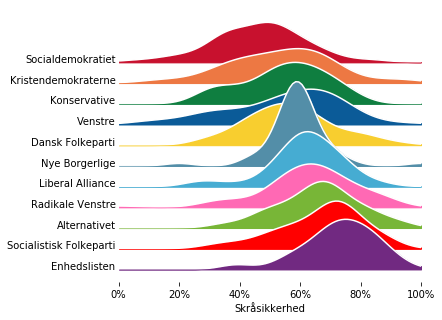

In [915]:
shift = 0.045
fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
cleanaxes(ax)
ax.get_yaxis().set_ticks([])
sortedparties = listdf.sort_values('certainty')
for i,(s,p) in enumerate(((s,p) for s,p in sortedparties.iterrows() if s in selectsymbols)):
    xs = np.linspace(0,30,100)
    ys = gaussian_kde(newdf[newdf.symbol == s].certainty, bw_method=None).evaluate(xs)
    plt.plot(xs/30*100,ys-i*shift,color='w',zorder=i)
    plt.fill_between(xs/30*100,ys-i*shift,-i*shift,color=p.farve,zorder=i)
    plt.axhline(-i*shift,color=p.farve,zorder=i, lw=0.5)
    plt.text(-1,-i*shift,p.shortname,zorder=i,ha='right')
plt.xlim(0,100)
ax.set_xticklabels([str(int(x))+'%' for x in ax.get_xticks()])
plt.xlabel('Skråsikkerhed')
plt.subplots_adjust(left=0.3)
plt.savefig('partisikkerhed.svg')
plt.savefig('partisikkerhed.pdf')

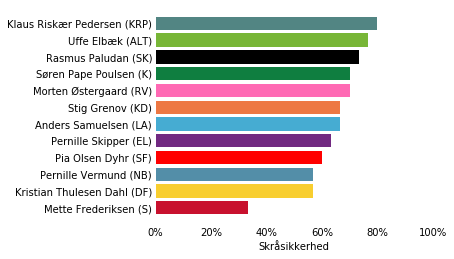

In [970]:
fig = plt.figure(figsize=(7,4))
ax = plt.subplot()
cleanaxes(ax)
tmpdf = newdf[newdf['navn'].isin(partiledere)].sort_values('certainty')
#plt.barh(tmpdf['navn'] + ' ('+tmpdf['symbol'].map(partifork)+')',tmpdf['certainty']/30*100,color=tmpdf['symbol'].map(partifarve))
plt.barh(tmpdf['navn'] + ' ('+tmpdf['symbol'].map(listdf.fork)+')',tmpdf['certainty']/30*100,color=tmpdf['symbol'].map(listdf.farve))
plt.xlim(0,100)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticks(range(0,101,20))
ax.set_xticklabels([str(int(x))+'%' for x in ax.get_xticks()])
plt.xlabel('Skråsikkerhed')
plt.subplots_adjust(left=0.35)
plt.savefig('formandsikkerhed.svg')
plt.savefig('formandsikkerhed.pdf')

# Particentre

In [523]:
listdf['center'] = listdf.index.map(lambda s: newdf['svar'][newdf.symbol == s].map(np.array).mean())

In [714]:
selectlistdf = listdf[listdf.index.isin(selectsymbols)]

In [1006]:
X_partier = selectlistdf['center'].apply(pd.Series)

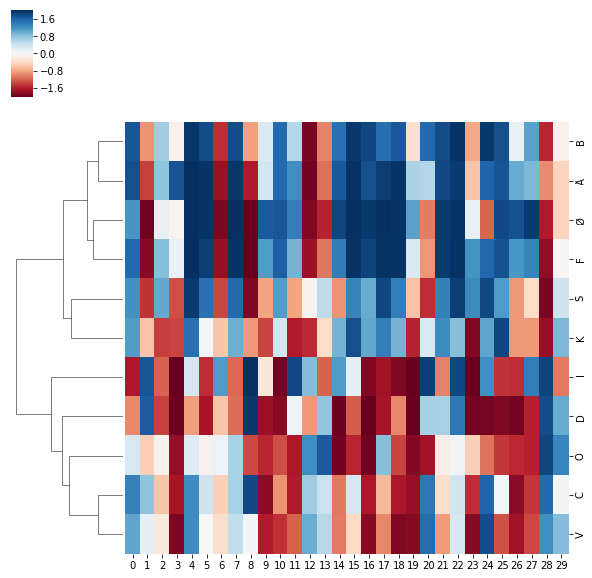

In [1270]:
sns.clustermap(X_partier, col_cluster=False, method='average', cmap='RdBu')

In [1010]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X_partier)

In [717]:
rot = PCA(n_components=2)
X_transformed = rot.fit_transform(X_transformed)

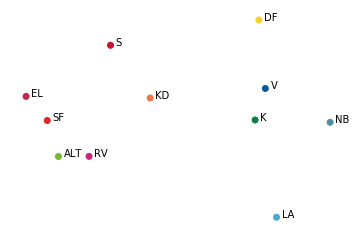

In [721]:
shift = 0.3
ax = plt.subplot()
ax.set_xticks([])
ax.set_yticks([])
plt.scatter(X_transformed[:,0],-X_transformed[:,1],c=selectlistdf.farve)
for (x,y),n in zip(X_transformed,selectlistdf.fork):
    plt.text(x+shift,-y,n)
cleanaxes(ax)
plt.savefig('partier.pdf')

# Afstand til center

In [866]:
newdf['partidist'] = np.sqrt(((newdf.svar - newdf.symbol.map(listdf.center))**2).map(sum))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


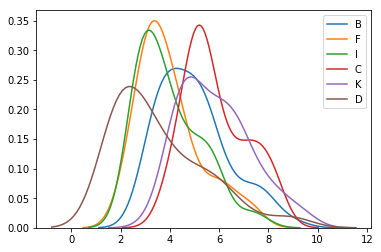

In [873]:
for s in selectsymbols[::2]:
    sns.kdeplot(newdf.partidist[newdf.symbol == s], label=s)

In [1232]:
def closest_party(cand):
    mindist = 10000
    closest = ''
    for idx,party in listdf.iterrows():
        if idx not in selectsymbols:
            continue
        dist = np.sqrt(np.sum((cand.svar - party.center)**2))
        if dist < mindist:
            mindist = dist
            closest = idx
    return closest

In [1235]:
newdf['closest'] = newdf.apply(closest_party, axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1238]:
wrong = newdf[newdf.closest != newdf.symbol]

In [1257]:
counts = (wrong.symbol + wrong.closest).value_counts()

In [1262]:
for i,c in counts.items():
    if 'P' not in i and 'UP' not in i and 'K' not in i:
        print(i,c)

VC 12
SF 7
ÅF 7
CV 7
ÅB 7
BÅ 6
FÅ 6
ØF 6
BS 5
FB 4
EB 4
EC 3
ØÅ 3
ES 3
FS 3
VO 2
CD 2
VD 1
ÅØ 1
VI 1
OV 1
ED 1
CI 1
EV 1
DO 1
EO 1
ID 1
SB 1
BF 1


# Forskellige projektioner

In [1491]:
X = newdf.svar.apply(pd.Series)

In [1488]:
def tmpfunc(x):
    if x == -2:
        return -3
    if x == 2:
        return 3
    return x
#X = X.applymap(tmpfunc)

## PCA

In [1085]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

In [1086]:
pca.explained_variance_ratio_

array([0.47104132, 0.10497657, 0.06160523, 0.0419528 ])

<BarContainer object of 30 artists>

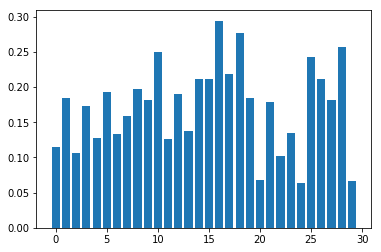

In [1087]:
plt.bar(range(30),np.abs(pca.components_[0]))

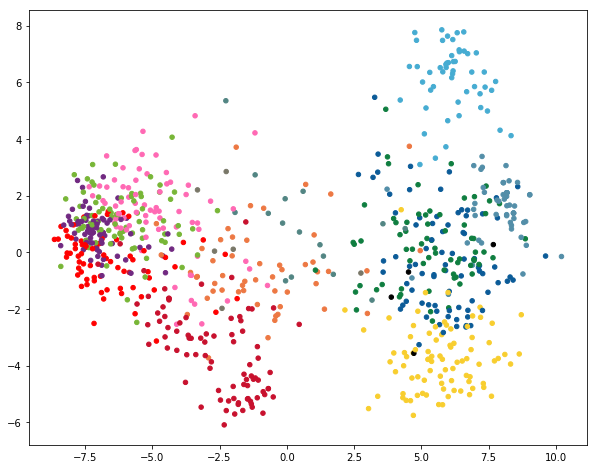

In [1088]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:,0], X_pca[:,1],c=newdf.symbol.map(listdf.farve),s=20)
#for (x,y),n in zip(X_pca[:,[0,1]],listdf.fork):
#    plt.text(x+shift,y,n)
plt.savefig('pca.pdf')

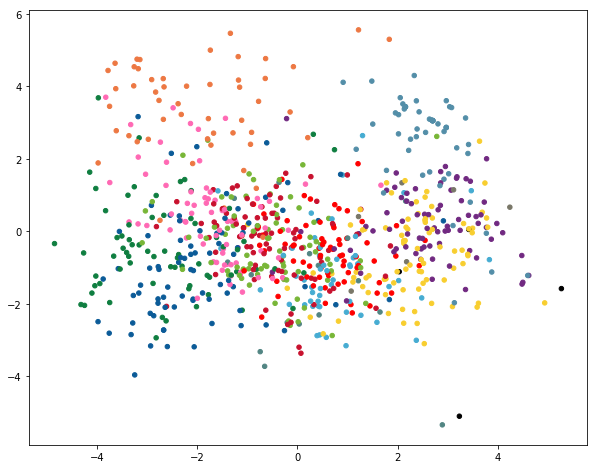

In [1089]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:,2], X_pca[:,3],c=newdf.symbol.map(listdf.farve),s=20)

## tSNE

In [1494]:
tsne = TSNE(n_components=2, init='pca', early_exaggeration=12)
X_tsne = tsne.fit_transform(scaler.fit_transform(X))
rot = PCA(n_components=2)
X_tsne = rot.fit_transform(X_tsne)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


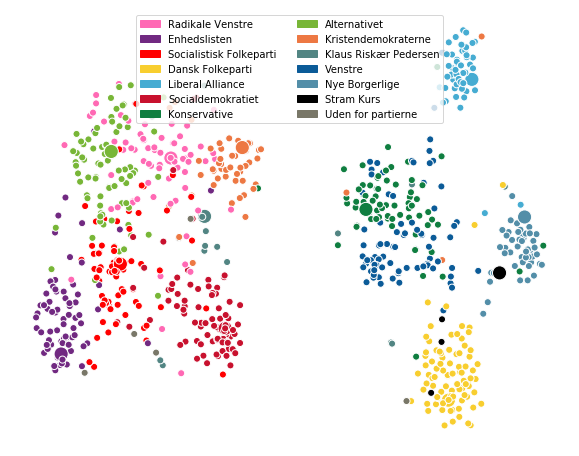

In [1495]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.set_xticks([])
ax.set_yticks([])
cleanaxes(ax)
plt.scatter(X_tsne[:,0], X_tsne[:,1],
            c=newdf.symbol.map(listdf.farve),
            s=newdf.navn.map(lambda x: 200 if x in partiledere else 50),
            edgecolors='w')


handles = [mpatches.Patch(color=p.farve, label=p.shortname) for i,p in listdf.iterrows()]
plt.legend(ncol=2,handles=handles)
plt.savefig('tsne.pdf')
plt.savefig('tsne.svg')

## MDS

In [1092]:
%%time
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X)

CPU times: user 35 s, sys: 4.15 s, total: 39.2 s
Wall time: 21.8 s


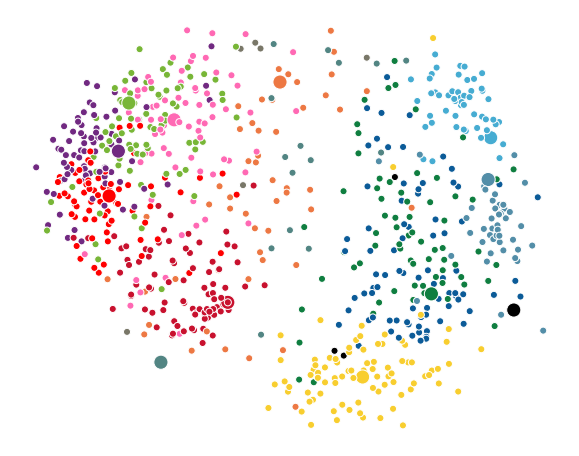

In [1096]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.set_xticks([])
ax.set_yticks([])
cleanaxes(ax)
plt.scatter(X_mds[:,0], X_mds[:,1],
            c=newdf.symbol.map(listdf.farve),
            s=newdf.navn.map(lambda x: 200 if x in partiledere else 50),
            edgecolors='w')

handles = [mpatches.Patch(color=p.farve, label=p.shortname) for i,p in listdf.iterrows()]
#plt.legend(ncol=2,handles=handles)
plt.savefig('mds.pdf')

## UMAP

In [1094]:
umap = UMAP(n_neighbors=10, min_dist=0.5,init='spectral')
X_umap = umap.fit_transform(X)

In [1095]:
rot = PCA(n_components=2)
X_umap = rot.fit_transform(X_umap)

In [1301]:
print(newdf.loc[290])
idx = newdf.index.get_loc(290)

navn                                            Inger Støjberg
storkreds                               Vestjyllands Storkreds
svar         [1, -1, -1, -2, 1, 1, -1, 1, -1, -2, -2, -2, 2...
symbol                                                       V
certainty                                                   16
partidist                                              3.78928
closest                                                      V
Name: 290, dtype: object


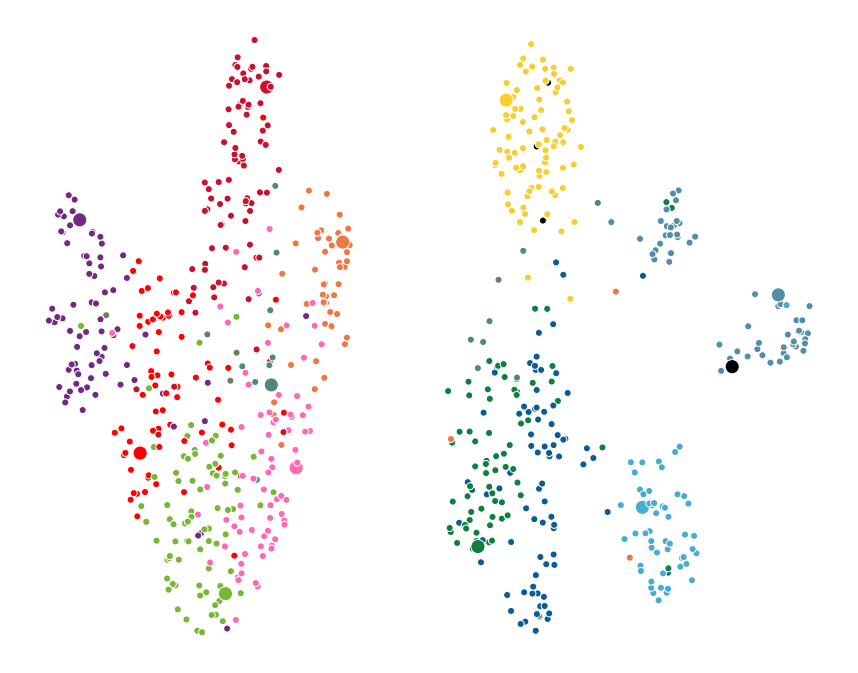

In [1303]:
plt.figure(figsize=(15,12))
ax = plt.subplot()
ax.set_xticks([])
ax.set_yticks([])
cleanaxes(ax)
plt.scatter(X_umap[:,0], X_umap[:,1],
            c=newdf.symbol.map(listdf.farve),
            s=newdf.navn.map(lambda x: 200 if x in partiledere else 50),
            edgecolors='w')

#plt.scatter(X_umap[idx,0],X_umap[idx,1],c='r',s=300)

handles = [mpatches.Patch(color=p.farve, label=p.shortname) for i,p in listdf.iterrows()]
#plt.legend(ncol=4,handles=handles)
plt.savefig('umap.pdf')
plt.savefig('umap.svg')

# Gentagene svar

In [1328]:
gengangere = newdf.svar.value_counts().head()
gengangere

[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, -1, 1, -2, -1, -2, -2, -1, -2, 1, 1, 2, -2, -2, -2, -2, -2, 2, 1]     7
[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, -1, -1, 1, -2, -1, -2, -2, -1, -2, 1, 1, 2, -2, -2, -2, -2, -2, 2, 1]    4
[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 2, -1, 1, -2, -1, -2, -2, -1, -2, 1, 1, 2, -2, -2, -2, -2, -2, 2, 1]     3
[1, -1, 1, -2, 2, 1, -1, 1, -2, -2, 1, -2, 1, 1, -2, 1, 1, 1, 1, -1, -2, 1, 2, 1, 2, 1, -1, -1, -2, 1]              2
[1, 1, -2, -2, -1, -2, -1, -1, 2, -2, -1, -1, -1, 1, -2, -2, -2, -2, -1, -2, 1, 2, 2, -2, -1, -2, -2, -2, -2, 1]    1
Name: svar, dtype: int64

In [1334]:
def findmatch(svar):
    ref = gengangere.index[0]
    return np.array_equal(svar, ref)
newdf[newdf.svar.map(findmatch)]

,navn,storkreds,svar,symbol,certainty,partidist,closest
143,Cherif Tomra Ayouty,Københavns Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
225,Gitte Keller,Vestjyllands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
321,Janni Walies,Sjællands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
616,Morten Filipsen,Sydjyllands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
633,Niels Børge Eriksen,Østjyllands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
828,Tina Hedegaard Pedersen,Vestjyllands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D
853,Ulla Kokfelt,Nordsjællands Storkreds,"[-1, 2, -2, -2, -1, -2, -1, -1, 2, -2, -2, 1, ...",D,18,1.693324,D


# Export data

In [1343]:
exportdf = newdf[['navn','symbol','storkreds','closest']]
exportdf = exportdf.assign(x=X_tsne[:,0])
exportdf = exportdf.assign(y=X_tsne[:,1])

In [1344]:
exportdf.to_csv('tsne.csv', index=False)

In [1346]:
corr = X.corr()

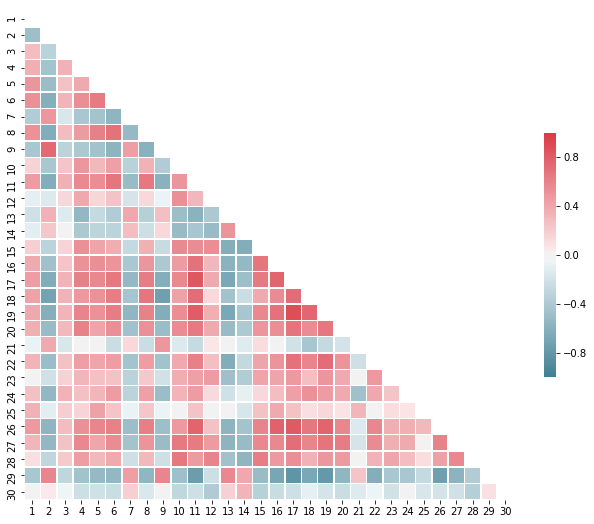

In [1506]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
maskcorr = (corr.applymap(np.abs) >= 0.0)*corr
sns.heatmap(maskcorr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, xticklabels=range(1,31),
            yticklabels=range(1,31), square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('corr.pdf')

# Clustering

## Dendrogram

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [1168]:
Z = linkage(X, 'ward')

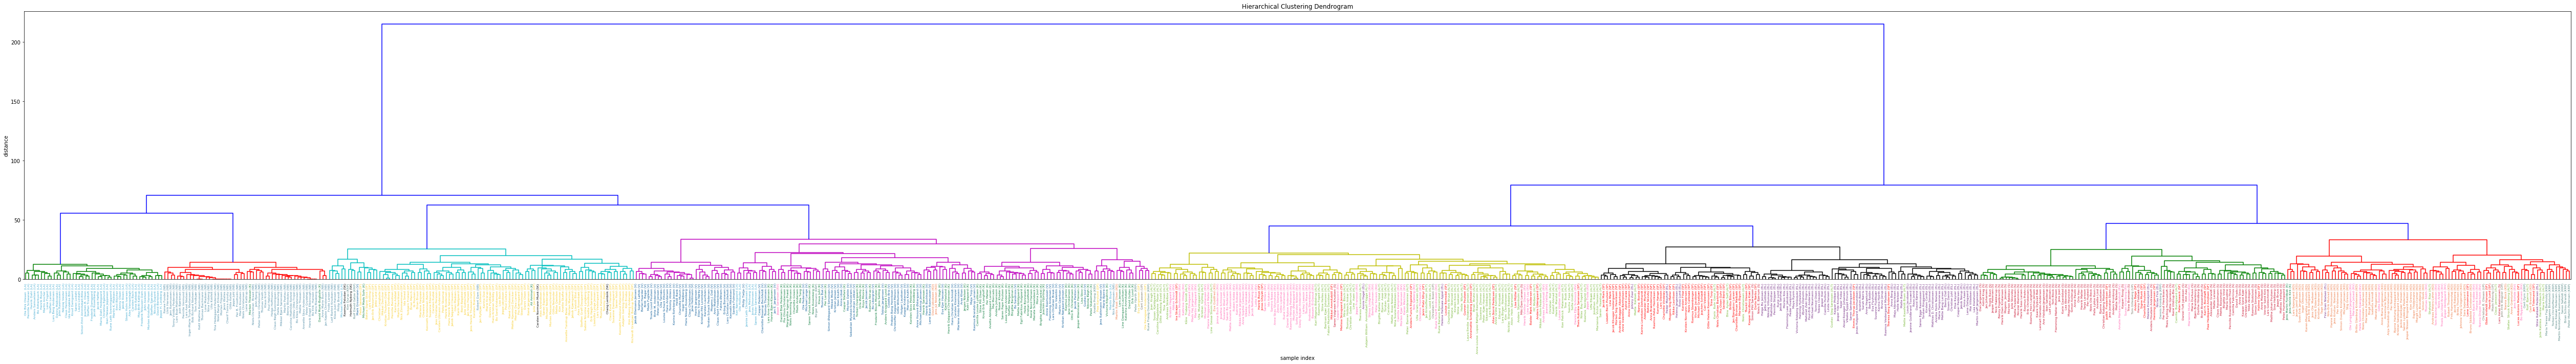

In [1175]:
plt.figure(figsize=(70, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=6.,  # font size for the x axis labels
    labels=list(newdf.index),
    orientation='top',
    color_threshold=40,
)
#plt.show()
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
labels = []
for i,lbl in enumerate(xlbls):
    pers = newdf.loc[int(lbl.get_text())]
    lbl.set_color(listdf.loc[pers.symbol].farve)
    newlabel = f'{pers.navn} ({listdf.loc[pers.symbol].fork})'
    labels.append(newlabel)
ax.set_xticklabels(labels)
#fig.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.savefig('dendrogram.pdf')

## K-means

In [1497]:
from sklearn.cluster import KMeans

In [1498]:
kmean = KMeans(n_clusters=11, init=selectlistdf.center.apply(pd.Series))

In [1499]:
newdf = newdf.assign(kmeans=kmean.fit_predict(X))

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


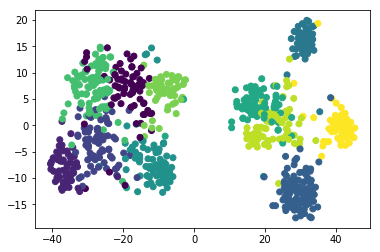

In [1500]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=newdf.kmeans)

In [1501]:
newdf.kmeans = newdf.kmeans.map(lambda x: selectlistdf.index[x])

In [1502]:
(newdf.symbol + ' -> ' + newdf.kmeans).value_counts()

O -> O     84
S -> S     76
Ø -> Ø     63
Å -> Å     63
V -> V     63
F -> F     56
D -> D     55
C -> C     55
I -> I     51
B -> B     47
K -> K     44
B -> Å     17
V -> C     13
C -> V     10
Å -> F      9
Ø -> F      8
S -> F      7
F -> Å      6
Å -> B      6
K -> B      5
E -> B      5
E -> C      5
B -> S      5
F -> B      5
B -> K      4
E -> K      3
Ø -> Å      3
P -> O      3
C -> D      3
F -> S      3
UP -> B     2
V -> O      2
V -> I      2
S -> B      2
UP -> Å     1
UP -> S     1
K -> D      1
B -> F      1
E -> S      1
I -> D      1
Ø -> K      1
UP -> O     1
K -> V      1
Å -> Ø      1
P -> D      1
D -> O      1
O -> D      1
E -> D      1
E -> O      1
C -> I      1
V -> D      1
UP -> Ø     1
F -> K      1
K -> C      1
dtype: int64

## GMM

In [1450]:
from sklearn.mixture import GaussianMixture

In [1456]:
gmm = GaussianMixture(n_components=11,
                      n_init=10,
                      covariance_type='full',
                        means_init=selectlistdf.center.apply(pd.Series))

In [1471]:
gmmlabels=gmm.fit_predict(X)

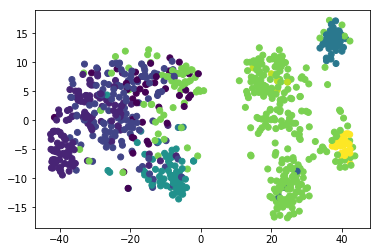

In [1472]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=gmmlabels)

In [1473]:
(newdf.symbol + gmmlabels.astype(str)).value_counts()

O8     82
V8     76
C8     68
Ø1     65
S5     64
Å2     50
F1     48
I4     46
B2     42
D10    35
K8     35
D8     21
Å1     20
B0     17
F2     16
S2     15
K0     13
E8     13
Ø2      8
B8      8
I8      6
Å0      5
V9      5
Å8      4
P8      4
K2      4
B5      3
S1      3
F0      3
F8      3
O3      3
B1      3
UP8     2
S8      2
UP5     2
UP4     1
E4      1
E1      1
F5      1
Ø0      1
Ø8      1
E0      1
C4      1
B4      1
S0      1
UP0     1
Name: symbol, dtype: int64

In [1105]:
Spca = PCA(n_components=4)
X_S = Spca.fit_transform(X[newdf.symbol == 'D'])

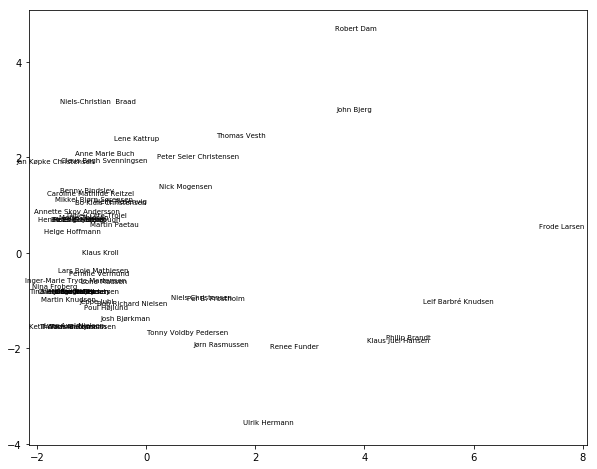

In [1106]:
plt.figure(figsize=(10,8))
plt.scatter(X_S[:,0],X_S[:,1],c='w')
for (x,y,*_),p in zip(X_S,newdf[newdf.symbol == 'D'].navn):
    plt.text(x,y,p,size=7,ha='center')

<BarContainer object of 30 artists>

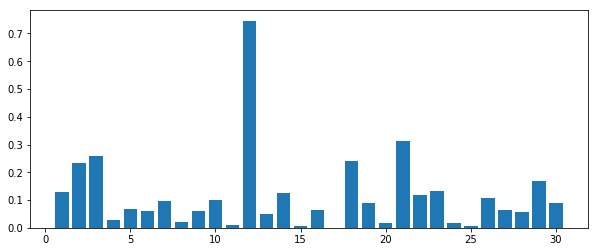

In [831]:
plt.figure(figsize=(10,4))
plt.bar(range(1,31),abs(Spca.components_[1]))

In [1198]:
(X.apply(pd.Series.value_counts).loc[[-2,2]].sum(axis=0) - X.apply(pd.Series.value_counts).loc[[-1,1]].sum(axis=0)).sort_values()

29   -193
13   -183
2     -59
6     -31
1     -13
0      21
20     45
23     49
9      77
11     79
26     79
7      91
19    101
10    107
21    111
5     135
12    149
3     195
27    207
25    223
15    229
24    243
17    287
4     289
22    297
14    313
18    361
8     373
28    411
16    427
dtype: int64